## Neural Language Model

Given some content $C$ as a sequence of words, and some words $x_1, \ldots, x_n$, a language model (LM) is modeling the conditional probability

\begin{equation}
  P \left( x_{n+1} \mid x_1, \ldots, x_n; C \right).
\end{equation}

The original nerual language model, a language model by neural netwok, is implemented by RNN. In the case of nerual machine translation (as a LM), it is a RNN auto-encoder. The encoder encodes the sentence from language A, as a sequence of words in A, to a vector; and then the decoder decodes the vector to language B, as another sequence of words in B.

<img src="https://cdn-images-1.medium.com/max/1200/0*H3OrEmG7Z1SgllAQ." alt="Drawing" style="width: 800px;"/>

## Backward of RNN Encoder

The information contained the final encoding vector is limited by the dimension of the vector. A `float32` value in range $(-1, 1)$ has $24$ bits. If the encoding dimension is $1000$ (large), then the total information is $1000 \times 24 = 24000$ bits. Can these bits encode all the poems of Shakespeare? No way!

The solution to this obstacle is, naturally, to use the full encoded sequence, instead of the last element of the sequence. This retains almost all the information.

However, at every step of decoding, not all the elements in the sequence are relavent. So, we, or say the machine, has to figure out the relavence. This is attention.

## Focus your Attention!

<img src="https://qph.fs.quoracdn.net/main-qimg-4af8f1e1933c5aa9f9f5a54838eedf98.webp" alt="Drawing" style="width: 800px;"/>

A detailed architecture:

<img src="https://github.com/GSimas/Deep-LearningAI/blob/master/Course%205/Week%203/Neural%20Machine%20Translation/images/attn_mechanism.png?raw=true" alt="Drawing" style="width: 500px;"/>

In [1]:
import abc
import tensorflow as tf


class BaseAttention(abc.ABC):
  """Abstract base class of attention."""
  
  # Abbreviations for shapes:
  #   batch_shape -> B (list of `int`s)
  #   seqlen -> L (`int`)
  #   query_dim -> Q (`int`)
  #   key_dim -> K (`int`)
  #   value_dim -> V (`int`)

  def __call__(self, query, keys, values, name='Attention'):
    """Returns the context, with attention-score.
    
    Args:
      query: Tensor with shape `batch_shape + [query_dim]`.
      keys: Tensor with shape `batch_shape + [seqlen, key_dim]`.
      values: Tensor with shape `batch_shape + [seqlen, value_dim]`.
      name: String.
      
    Returns:
      Tuple of two tensors. The first with shape `batch_shape + [value_dim]`
      as the context; and the second with shape `batch_shape + [seqlen]` as
      the attention-score.
    """
    with tf.name_scope(name):
      score = self._score(query, keys)  # B + [L, 1]
      # score * values: B + [L, V]
      context = tf.reduce_sum(score * values, axis=-2)  # B + [V]
      score = tf.squeeze(score, axis=-1)  # B + [L]
      return score, context

  def _score(self, query, keys, name='attention_score'):
    """Returns the attention-score.

    Args:
      query: Tensor with shape `batch_shape + [query_dim]`.
      keys: Tensor with shape `batch_shape + [seqlen, key_dim]`.
      name: String.
      
    Returns:
      Tensor with shape `batch_shape + [seqlen, 1]`. The additional `1`
      is made for convienence for being contracted by a "values" tensor
      with shape `batch_shape + [seqlen, value_dim]` along the `seqlen`
      axis.
    """
    with tf.name_scope(name):
      with tf.name_scope('repeat'):  # along `seqlen`-axis.
        query = tf.expand_dims(query, axis=-2)  # B + [1, Q]
        query = tf.tile(query, self._get_repeats(keys))  # B + [L, Q]

      concated = tf.concat([query, keys], axis=-1)  # B + [L, Q+K]
      energy = self.energy(concated)  # B + [L, 1]
      # Softmax along the `L`-axis
      attention_score = tf.nn.softmax(energy, axis=-2)  # B + [L, 1]
      return attention_score

  def _get_repeats(self, keys):
    """Returns the `repeats` argument of the `tf.tile()` in `self.__call__()`."""
    with tf.name_scope('repeats'):
      shape = keys.get_shape().as_list()
      rank = len(shape)
      seqlen = shape[-2]
      return [1] * (rank - 2) + [seqlen, 1]

  @abc.abstractmethod
  def energy(self, x):
    """
    Args:
      x: Tensor with shape `batch_shape + [query_dim + key_dim]`.

    Returns:
      Tensor with shape `batch_shape + [1]`.
    """
    pass

## A Simple Example

We show up a simple enough example found in [Ng's course](https://github.com/GSimas/Deep-LearningAI/tree/master/Course%205/Week%203/Neural%20Machine%20Translation). This is a simple neural machine translation model that converts date-format from the natural language format for human to the standard format for machine.

### Date-Format Data

In [2]:
import numpy as np
from nmt_utils import load_dataset, preprocess_data

dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(10000)

100%|██████████| 10000/10000 [00:00<00:00, 17223.09it/s]


Some instances:

In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

The vocabularies for both human and machine are character-level:

In [4]:
print('Human vocabulary:', human_vocab, '\n')
print('Machine vocabulary:', machine_vocab)

Human vocabulary: {' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36} 

Machine vocabulary: {'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}


Preprocessing to model inputs:
  1. replacing unknown with "<unk>"; 
  1. post-padding;
  1. the inputs and outputs (targets) are all in one-hot format.

In [5]:
input_seqlen = 30
output_seqlen = 10
X, y, X_oh, y_oh = preprocess_data(
    dataset, human_vocab, machine_vocab, input_seqlen, output_seqlen)

In [6]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", y[index])
print()
print("Source after preprocessing (one-hot):", X_oh[index])
print("Target after preprocessing (one-hot):", y_oh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### RNN Auto-Encoder with Attention

The model is illustrated as follow:

<img src="https://github.com/GSimas/Deep-LearningAI/blob/master/Course%205/Week%203/Neural%20Machine%20Translation/images/attn_model.png?raw=true" alt="Drawing" style="width: 650px;"/>

And now let's implement it.

In [7]:
from tensorflow.keras.layers import Bidirectional, Dense, Dropout
from tfutils.initializer import GlorotInitializer

if tf.test.is_gpu_available():
    from tensorflow.keras.layers import CuDNNLSTM as LSTM
else:
    from tensorflow.keras.layers import LSTM    


class Attention(BaseAttention):
  
  def __init__(self, energy_units, **kwargs):
    super().__init__(**kwargs)
    self._layers = []
    for n in energy_units:
      self._layers += [tf.layers.Dense(n, activation=tf.nn.relu),
                       tf.layers.Dropout()]
    self._layers += [tf.layers.Dense(1)]
    
  def energy(self, x):
    with tf.name_scope('energy'):
      for layer in self._layers:
        x = layer(x)
      return x


def model_fn(features, labels, mode, params):
  """The `labels` is one-hot."""
  pre_rnn = Bidirectional(LSTM(params['pre_lstm_units'],
                               return_sequences=True))
  attention = Attention(params['energy_units'])
  post_rnn = LSTM(params['post_lstm_units'],
                  return_state=True)
  # Returns the logits
  output_layer = Dense(params['output_vocab_size'])

  # [batch_size, post_lstm_units]
  s = features['init_s']
  c = features['init_c']
  # [batch_size, input_seqlen, input_vocab_size]
  onehot_inputs = features['onehot_inputs']
  # [batch_size, input_seqlen, pre_lstm_units * 2]
  a_seq = pre_rnn(onehot_inputs)

  # Implements the loop
  output_seqlen = tf.constant(params['output_seqlen'])
  logits = tf.TensorArray(dtype=s.dtype, size=output_seqlen)
  attention_scores = tf.TensorArray(dtype=s.dtype, size=output_seqlen)

  def cond(logits, attention_scores, s, c, step):
    return tf.less(step, output_seqlen)

  def body(logits, attention_scores, s, c, step):
    # [batch_size, input_seqlen] and
    # [batch_size, pre_lstm_units * 2]
    attention_score, context = attention(s, a_seq, a_seq)

    with tf.name_scope('logit'):
      # Prepare for inputting `post_rnn`
      # [batch_size, 1, pre_lstm_units * 2]
      context = tf.expand_dims(context, axis=-2)
      # [batch_size, post_lstm_units]
      s, _, c = post_rnn(context, initial_state=[s, c])
      # [batch_size, output_vocab_size]
      logit = output_layer(s)

    logits = logits.write(step, logit)
    attention_scores = attention_scores.write(step, attention_score)
    return logits, attention_scores, s, c, (step + 1)
  
  logits, attention_scores, *_ = tf.while_loop(
      cond, body, loop_vars=[logits, attention_scores, s, c, 0])

  # Postprocess the TensorArray
  # [output_seqlen, batch_size, output_vocab_size]
  logits = logits.stack()
  # [batch_size, output_seqlen, output_vocab_size]
  logits = tf.transpose(logits, [1, 0, 2])
  # [output_seqlen, batch_size, input_seqlen]
  attention_scores = attention_scores.stack()
  # [batch_size, output_seqlen, input_seqlen]
  attention_scores = tf.transpose(attention_scores, [1, 0, 2])

  # [batch_size, output_seqlen, output_vocab_size]
  predict_probs = tf.nn.softmax(logits, axis=-1)
  # [batch_size, output_seqlen]
  predict_classes = tf.argmax(logits, axis=-1)
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'logits': logits,
        'probs': predict_probs,
        'class_ids': predict_classes,
        'attention_scores': attention_scores,
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  loss = tf.losses.softmax_cross_entropy(labels, logits)
  
  # [batch_size, output_seqlen]
  label_classes = tf.argmax(labels, axis=-1)
  accuracy = tf.metrics.accuracy(
      label_classes, predict_classes, name='acc_op')
  metrics = {'accuracy': accuracy}
  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode, loss=loss, eval_metric_ops=metrics)

  assert mode == tf.estimator.ModeKeys.TRAIN
  optimizer = tf.train.AdamOptimizer(params['lr'])
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [8]:
tf.reset_default_graph()

params={
    'lr': 0.05,
    'output_vocab_size': y_oh.shape[-1],
    'pre_lstm_units': 32,
    'energy_units': [128],
    'post_lstm_units': 64,
    'output_seqlen': y_oh.shape[-2],
}

estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   params=params)

print('\n', params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4n0pb66v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc45ae1ecc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

 {'lr': 0.05, 'output_vocab_size': 11, 'pre_lstm_units': 32, 'energy_units': [128], 'post_lstm_units': 64, 'output_seqlen': 10}


### Train and Evaluate the Model

In [9]:
def train_input_fn(X_oh, y_oh, init_s, init_c, batch_size):
    """An input function for training"""
    features = {'onehot_inputs': X_oh, 'init_s': init_s, 'init_c': init_c}
    dataset = tf.data.Dataset.from_tensor_slices((features, y_oh))
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset


def eval_input_fn(X_oh, y_oh, init_s, init_c, batch_size):
    """An input function for evaluating and predicting."""
    features = {'onehot_inputs': X_oh, 'init_s': init_s, 'init_c': init_c}
    if y_oh is None:
        dataset = tf.data.Dataset.from_tensor_slices(features)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((features, y_oh))
    dataset = dataset.batch(batch_size)  # shall NOT shuffle and repeat!
    return dataset
  
  
def get_inits(n_data, params):
    init_s = np.zeros([n_data, params['post_lstm_units']], dtype='float32')
    init_c = np.zeros([n_data, params['post_lstm_units']], dtype='float32')
    return init_s, init_c

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_oh, y_oh)

In [11]:
init_s, init_c = get_inits(X_train.shape[0], params)
estimator.train(
    input_fn=lambda: train_input_fn(X_train, y_train, init_s, init_c, 100),
    steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp4n0pb66v/model.ckpt.
INFO:tensorflow:loss = 2.4025064, step = 0
INFO:tensorflow:global_step/sec: 29.869
INFO:tensorflow:loss = 0.8244829, step = 100 (3.349 sec)
INFO:tensorflow:global_step/sec: 37.2547
INFO:tensorflow:loss = 0.14884116, step = 200 (2.684 sec)
INFO:tensorflow:global_step/sec: 36.8435
INFO:tensorflow:loss = 0.007106445, step = 300 (2.714 sec)
INFO:tensorflow:global_step/sec: 36.9819
INFO:tensorflow:loss = 0.0022480497, step = 400 (2.704 sec)
INFO:tensorflow:global_step/sec: 37.013
INFO:tensorflow:loss = 0.01661434, step = 500 (2.702 sec)
INFO:tensorflow:global_step/sec: 36.7233
INFO:tensorflow:loss = 0.010409214, step = 600 (2.723 sec)
INFO:tensorflow:global_step/sec: 37.1102
INFO:tens

In [12]:
init_s, init_c = get_inits(X_test.shape[0], params)
estimator.evaluate(input_fn=lambda: eval_input_fn(
    X_test, y_test, init_s, init_c, batch_size=128))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-12-09:31:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4n0pb66v/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-12-09:31:09
INFO:tensorflow:Saving dict for global step 2000: accuracy = 1.0, global_step = 2000, loss = 4.37774e-05
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp4n0pb66v/model.ckpt-2000


{'accuracy': 1.0, 'loss': 4.37774e-05, 'global_step': 2000}

### It Works

In [13]:
from typing import List, Dict


def pad(input_seqlen: int,
        chars: List[str],
        ) -> List[str]:
    chars = chars[:input_seqlen]
    chars += ['<pad>'] * (input_seqlen - len(chars))
    return chars
  

def unk(input_vocab: Dict[str, int],
        chars: List[str],
        ) -> List[str]:
    chars = [c if c in input_vocab else '<unk>' for c in chars]
    return chars
  
  
def onehot(input_vocab: Dict[str, int],
           chars: List[str],
           ) -> List[List[int]]:
    # To indices
    indices = [input_vocab[c] for c in chars]
    # To onehot, shape `[input_seqlen, input_vocab_size]`
    return [[1 if i == index else 0 for i, _ in enumerate(input_vocab)]
            for index in indices]


def preprocess_sources(sources: List[str],
                       input_seqlen: int,
                       input_vocab: Dict[str, int]
                       ) -> np.array:

    def preprocess_source(source: str) -> List[List[int]]:
        chars = [c for c in source.lower()]
        chars = unk(input_vocab, chars)
        chars = pad(input_seqlen, chars)
        return onehot(input_vocab, chars)

    # [len(sources), input_seqlen, input_vocab_size]
    return np.array([preprocess_source(_) for _ in sources],
                    dtype='float32')


def postprocess(sources: List[str], predictions: dict) -> List[dict]:
    all_processed = []
    for src, pred in zip(sources, predictions):
        prediction = ''.join(inv_machine_vocab[_] for _ in pred['class_ids'])    
        processed = {
            'source': src,
            'prediction': prediction,
            'attention_scores': pred['attention_scores'],
            'logits': pred['logits']
        }
        all_processed.append(processed)
    return all_processed

In [14]:
sources = [
  '3 May 2079', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007',
  'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001'
]

X_oh_pred = preprocess_sources(sources, X_oh.shape[-2], human_vocab)
n_data_pred = X_oh_pred.shape[0]
input_seqlen = X_oh_pred.shape[1]
init_s_pred, init_c_pred = get_inits(len(sources), params)
predicted = estimator.predict(input_fn=lambda: eval_input_fn(
    X_oh_pred, None, init_s_pred, init_c_pred, batch_size=128))
predictions = postprocess(sources, predicted)

for src, pred in zip(sources, predictions):
  print(src)
  print(pred['prediction'])
  print()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4n0pb66v/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
3 May 2079
2979-05-03

5 April 09
2009-04-05

21th of August 2016
2016-08-21

Tue 10 Jul 2007
2007-07-10

Saturday May 9 2018
2018-05-09

March 3 2001
2001-03-03

March 3rd 2001
2001-03-03

1 March 2001
2001-03-01



## Why Attention

The attention has one advantage that almost any other NN architecture absents, that is, the explainability!

In [15]:
import matplotlib.pyplot as plt
from typing import List

def plot_attention(attention: np.array,
                   source: str,
                   prediction: str,
                   figsize=(7, 7)):
    
    def preprocess(s: str) -> List[str]:
      return ['*' if c == ' ' else c for c in s.lower()]
    
    source = preprocess(source)
    prediction = preprocess(prediction)
    attention = attention[:len(prediction), :len(source)]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    # Set axes
    fontdict = {'fontsize': 12}
    ax.set_xticks(range(0, len(source)))
    ax.set_xticklabels(source, fontdict=fontdict)
    ax.set_yticks(range(0, len(prediction)))
    ax.set_yticklabels(prediction, fontdict=fontdict)

    plt.show()

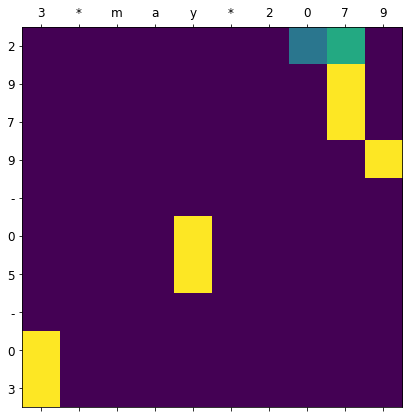

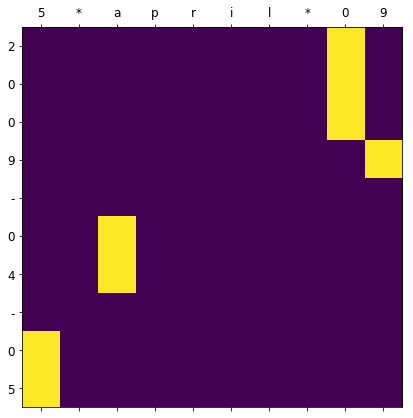

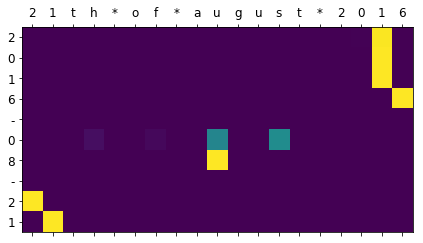

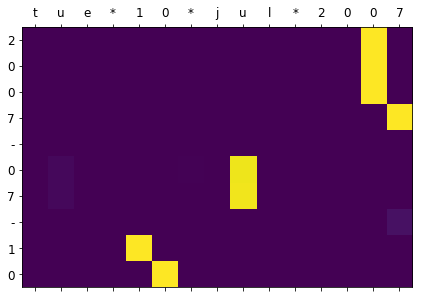

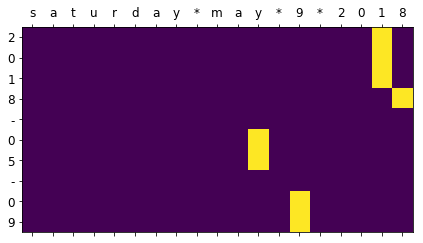

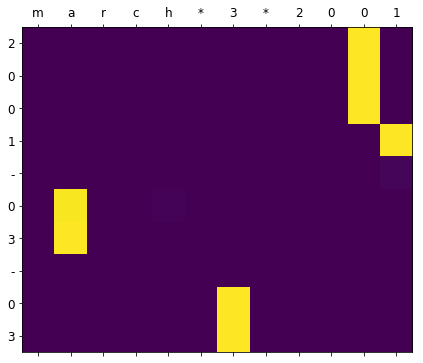

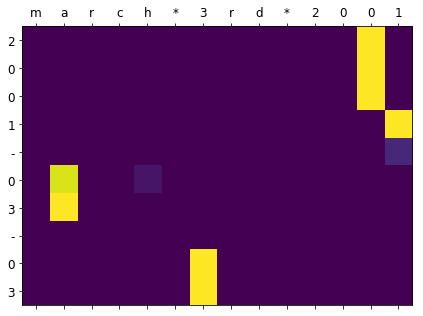

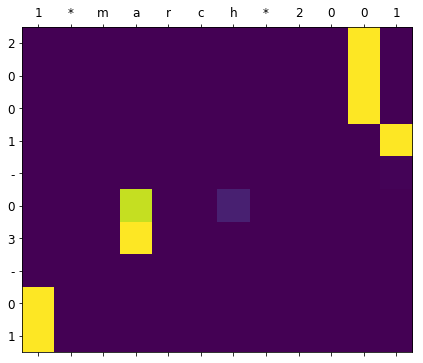

In [16]:
for pred in predictions:
    plot_attention(pred['attention_scores'], pred['source'], pred['prediction'])

The bi-LSTM mixes the characters in neighbour together because of its bi-directional memory, so in these plots, shifting exists.